Отслеживание и предсказание отказа оборудования помогает избежать внезапных ситуаций, спрогнозировать их заранее. При помощи прогноза можно осуществить плановый ремонт оборудования заранее (до поломки) и сэкономить ресурсы.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics

from pandas_profiling import ProfileReport

data glowbyte.zip                      hometask_motors_TyaShenTin_Yegor.html
data.csv                               hometask_motors_TyaShenTin_Yegor.ipynb
example                                renessanse
fig


In [3]:
df = pd.read_csv('data.csv')
df

FileNotFoundError: [Errno 2] File b'unemployments.csv' does not exist: b'unemployments.csv'

Исходя из описания задания:
- id - идентификатор мотора,
- cycle - цикл работы,
- p00-p20 - показания датчиков считываемые в процессе работы,
- s0, s1 - настройки изменяемые в конце каждого цикла.
    
Решить задачу прогнозирования отказа моторов можно при помощи различных методов: 
- регрессии,
- бинарной классификации,
- мультиклассовой классификации.

Я решил сделать это при помощи регрессии.
Нам необходимо предсказывать число циклов работы мотора, которые могут успешно пройти до появления критических неисправностей.

Имея данные, которые у нас есть можно вычислить для каждого мотора в отдельный момент времени (номер цикла) количество циклов, которое ещё мотор проработает.

In [270]:
# Добавление столбца, которой показывает количество циклов до поломки

df['cycles_until_failure'] = df.groupby(['id'])['cycle'].transform(max)-df['cycle']

In [271]:
# Разделяем обучающую выборку и тестовую выборку в соотношении (70/30)
df_train = df[:14500]
df_test = df[14500:]

In [272]:
pd.DataFrame.describe(df)

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p14,p15,p16,p17,p18,p19,p20,s1,s2,cycles_until_failure
count,16138.000000,16138.000000,1.613800e+04,1.613800e+04,16138.000000,16138.000000,16138.000000,16138.000000,16138.000000,1.613800e+04,...,16138.000000,16138.000000,1.613800e+04,16138.000000,16138.000000,16138.000000,16138.000000,16138.000000,1.613800e+04,16138.000000
mean,40.707894,105.548147,5.186700e+02,1.300000e+00,47.544263,521.405420,2388.096737,8143.933458,8.442581,3.000000e-02,...,1590.582096,1409.033729,1.462000e+01,21.609795,553.359776,2388.097368,9065.461291,0.000010,6.196555e-08,104.548147
std,23.395354,65.915295,6.275708e-11,3.932532e-13,0.267422,0.738252,0.072604,19.731349,0.037520,1.230304e-14,...,6.129960,8.977073,3.044770e-12,0.001417,0.887947,0.071608,22.781362,0.002188,2.939096e-04,65.915295
min,1.000000,1.000000,5.186700e+02,1.300000e+00,46.860000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,...,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,-0.008600,-6.000000e-04,0.000000
25%,20.000000,51.000000,5.186700e+02,1.300000e+00,47.350000,520.940000,2388.040000,8132.830000,8.415300,3.000000e-02,...,1586.330000,1402.500000,1.462000e+01,21.610000,552.800000,2388.050000,9052.820000,-0.001400,-3.000000e-04,50.000000
50%,42.000000,101.000000,5.186700e+02,1.300000e+00,47.520000,521.460000,2388.090000,8140.750000,8.439800,3.000000e-02,...,1590.190000,1408.220000,1.462000e+01,21.610000,553.430000,2388.090000,9060.750000,0.000000,0.000000e+00,100.000000
75%,61.000000,153.000000,5.186700e+02,1.300000e+00,47.710000,521.940000,2388.140000,8148.817500,8.466000,3.000000e-02,...,1594.450000,1414.650000,1.462000e+01,21.610000,554.000000,2388.140000,9069.940000,0.001500,3.000000e-04,152.000000
max,80.000000,362.000000,5.186700e+02,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,...,1614.930000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,0.008700,6.000000e-04,361.000000


In [247]:
# Выводим статистическую информацию о данных
profile = ProfileReport(df, title='Pandas Profiling Report')


In [248]:
profile

In [249]:
features_orig = ['p00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 's1', 's2']

# Берём признаки, у которых высокая корелляция с номером цикла работы мотора

features_for_using = ['p02', 'p03', 'p04', 'p05', 'p06', 'p08', 'p11', 'p12', 'p13', 'p14', 'p15', 'p18', 'p19', 'p20']

features = features_for_using

In [250]:
X_train = df_train[features]
y_train = df_train['cycles_until_failure']

X_test = df_test[features]
y_test = df_test['cycles_until_failure']

In [251]:
def get_regression_metrics(model, actual, predicted):
    
    """Calculate main regression metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

In [252]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    
    """Plot regression coefficients weights or feature importance.
    
    Args:
        model (str): The model name identifier
        weights (array): Contains the regression coefficients weights or feature importance
        feature_names (list): Contains the corresponding features names
        weights_type (str): 'c' for 'coefficients weights', otherwise is 'feature importance'
        
    Returns:
        plot of either regression coefficients weights or feature importance
        
    
    """
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

In [253]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    
    """Print the regression residuals.
    
    Args:
        model (str): The model name identifier
        y_train (series): The training labels
        y_train_pred (series): Predictions on training data
        y_test (series): The test labels
        y_test_pred (series): Predictions on test data
        
    Returns:
        Plot of regression residuals
    
    """
    
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

In [254]:
# Линейная регрессия

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics

R^2 training: 0.591, R^2 test: 0.614


,Linear Regression
Root Mean Squared Error,37.683573
Mean Absolute Error,30.066212
R^2,0.613832
Explained Variance,0.615946


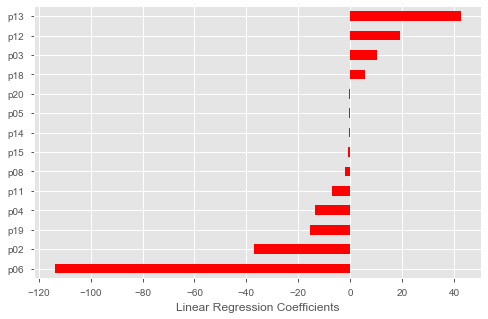

In [255]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

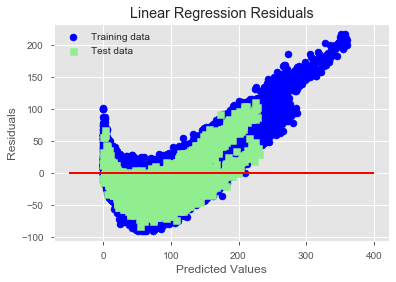

In [256]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

In [257]:
# Полиномиальная регрессия

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.637, R^2 test: 0.672


,Polynomial Regression
Root Mean Squared Error,34.746597
Mean Absolute Error,27.486976
R^2,0.671680
Explained Variance,0.676933


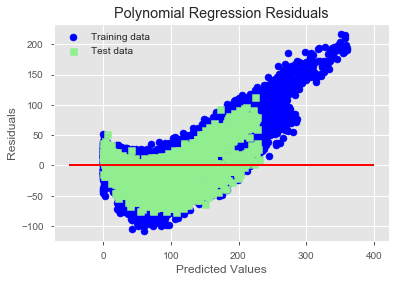

In [258]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)


In [259]:
# Decision Tree regressor

dtrg = DecisionTreeRegressor(max_depth=7, max_features=12, random_state=123) # selected features
#dtrg = DecisionTreeRegressor(max_depth=7, random_state=123)
dtrg.fit(X_train, y_train)

y_test_predict = dtrg.predict(X_test)
y_train_predict = dtrg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

dtrg_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_test_predict)
dtrg_metrics

R^2 training: 0.645, R^2 test: 0.622


,Decision Tree Regression
Root Mean Squared Error,37.273745
Mean Absolute Error,28.544300
R^2,0.622186
Explained Variance,0.623981


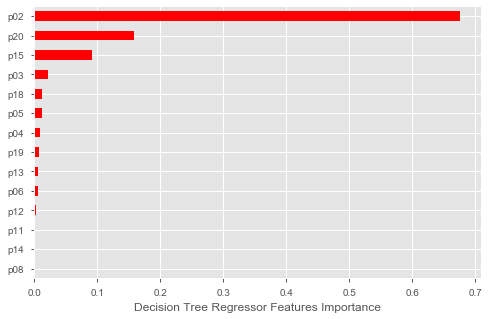

In [260]:
plot_features_weights('Decision Tree Regressor', dtrg.feature_importances_, X_train.columns, 't' )


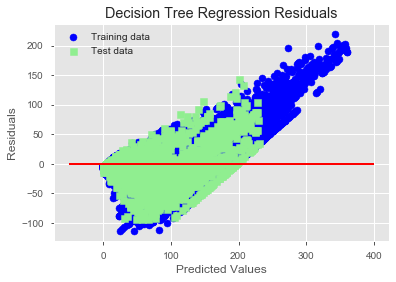

In [261]:
plot_residual('Decision Tree Regression', y_train_predict, y_train, y_test_predict, y_test)


In [262]:
# Random Forest

rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=7, n_jobs=-1, random_state=1)

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.667, R^2 test: 0.651


,Random Forest Regression
Root Mean Squared Error,35.807097
Mean Absolute Error,27.393978
R^2,0.651333
Explained Variance,0.652096


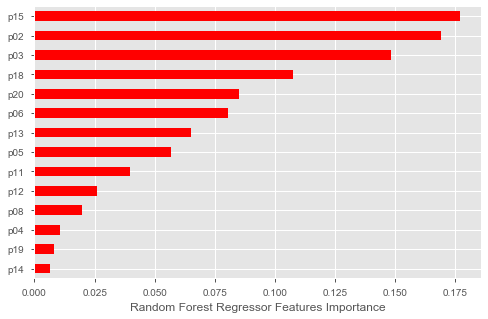

In [263]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )


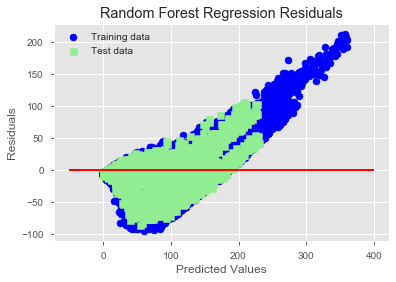

In [264]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)


In [265]:
# Сравним реальные и предсказанные значения

rf_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_test_predict
            }
    
rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred

,14500,14501,14502,14503,14504,14505,14506,14507,14508,14509,...,16128,16129,16130,16131,16132,16133,16134,16135,16136,16137
Actual,50.000000,49.000000,48.000000,47.000000,46.000000,45.000000,44.000000,43.000000,42.000000,41.000000,...,9.000000,8.000000,7.00000,6.000000,5.000000,4.000000,3.0000,2.000000,1.000000,0.000000
Prediction,85.098156,59.031403,69.172387,90.874818,59.259382,41.882231,58.458921,51.184639,97.133396,67.798059,...,15.611616,9.120503,12.72385,9.961218,8.167317,6.778462,5.3081,5.333529,6.422536,6.776242


In [266]:
# Также я поробовал использовать XGBoost (до я с ним не работал), варьируя гиперпараметры, получилось добиться приемлимого результата

xgdmat=xgb.DMatrix(X_train,y_train)
our_params={'learning_rate':0.2, 'subsample':0.8, 'max_depth':8}
final_gb=xgb.train(our_params,xgdmat)
tesdmat=xgb.DMatrix(X_test)
y_pred=final_gb.predict(tesdmat)

In [267]:
xg_metrics = get_regression_metrics('XGBoost', y_test, y_pred)
xg_metrics

,XGBoost
Root Mean Squared Error,35.112559
Mean Absolute Error,26.174975
R^2,0.664728
Explained Variance,0.684721


In [268]:
xg_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_pred
            }
    
xg_pred = pd.DataFrame.from_dict(xg_pred_dict).T
xg_pred

,14500,14501,14502,14503,14504,14505,14506,14507,14508,14509,...,16128,16129,16130,16131,16132,16133,16134,16135,16136,16137
Actual,50.000000,49.000000,48.000000,47.000000,46.000000,45.000000,44.000000,43.000000,42.000000,41.000000,...,9.000000,8.000000,7.000000,6.000000,5.000000,4.000000,3.000000,2.000000,1.000000,0.000000
Prediction,81.596909,50.358467,61.311584,59.258915,40.795013,31.882328,30.182089,34.058472,60.296085,49.227474,...,11.275752,6.224986,6.246441,6.848634,3.797889,6.283579,2.469499,2.231054,3.640985,3.136047


In [269]:
# Сравним итоговые результаты

reg_metrics_bfe = pd.concat([linreg_metrics, dtrg_metrics, polyreg_metrics, rf_metrics, xg_metrics], axis=1)
reg_metrics_bfe

,Linear Regression,Decision Tree Regression,Polynomial Regression,Random Forest Regression,XGBoost
Root Mean Squared Error,37.683573,37.273745,34.746597,35.807097,35.112559
Mean Absolute Error,30.066212,28.544300,27.486976,27.393978,26.174975
R^2,0.613832,0.622186,0.671680,0.651333,0.664728
Explained Variance,0.615946,0.623981,0.676933,0.652096,0.684721


Наилучшие результаты показали модели Random Forest и XGBoost.

Доп. задание: Задачу можно было усложнить, предложив реализовать мультиклассовую классификацию отказа моторов.
    На каждой итерации работы мотора его состояние необходимо соотнести с одним из трёх (опционально) классов:
0. исправно работающий мотор
1. мотор, которому в скором времени понадобится ремонт
2. мотор, который скоро выйдет из строя.